# **도표 13-8. 출고 누적과 재고 누적의 모델군 CBM그래프에 대한 무료 버전**

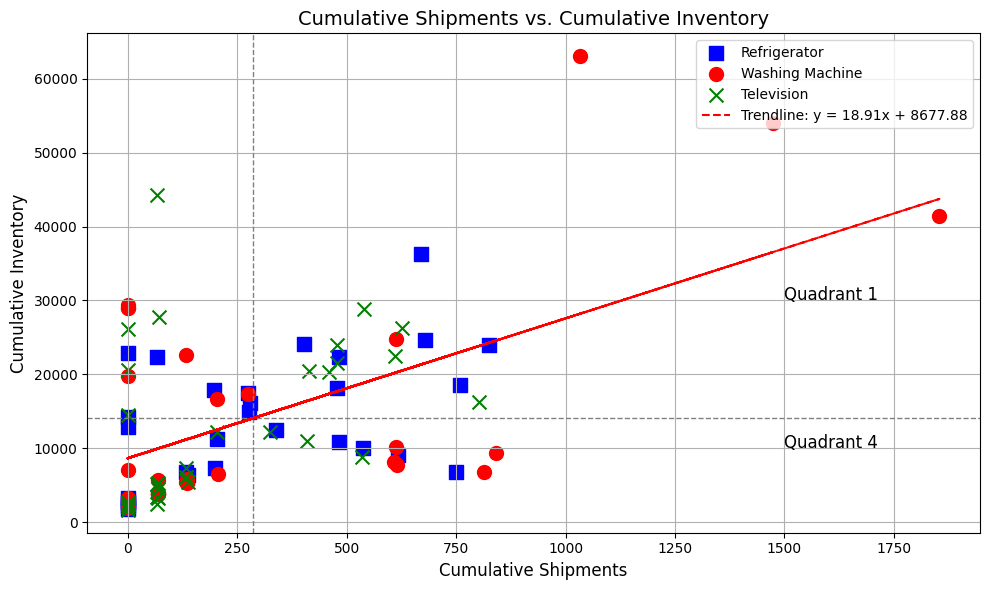

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 파일 읽기
base_inventory = pd.read_excel('/content/sample_data/기초재고.xlsx')
incoming = pd.read_excel('/content/sample_data/입고.xlsx')
outgoing = pd.read_excel('/content/sample_data/출고.xlsx')
model_info = pd.read_excel('/content/sample_data/모델코드.xlsx')

# 2. 데이터 병합 및 일별 재고 계산
dates = incoming.columns[1:]  # 날짜 컬럼 추출
results = []

for model in base_inventory['모델코드']:
    base_stock = base_inventory.loc[base_inventory['모델코드'] == model, '기초재고'].values[0]
    daily_incoming = incoming.loc[incoming['모델코드'] == model, dates].values.flatten()
    daily_outgoing = outgoing.loc[outgoing['모델코드'] == model, dates].values.flatten()
    daily_stock = [base_stock]

    for day_in, day_out in zip(daily_incoming, daily_outgoing):
        new_stock = daily_stock[-1] + day_in - day_out
        daily_stock.append(new_stock)

    for date, out, inp, stock in zip(dates, daily_outgoing, daily_incoming, daily_stock[1:]):
        weekday = pd.to_datetime(date).strftime('%A')
        results.append([model, date, out, inp, weekday, base_stock, stock])
        base_stock = stock

# 데이터프레임 생성
result_df = pd.DataFrame(results, columns=['Model Code', 'Date', 'Outgoing Quantity', 'Incoming Quantity', 'Weekday', 'Opening Stock', 'Closing Stock'])

# 3. 누적 출고 및 재고 계산
cumulative = result_df.groupby('Model Code').agg({'Outgoing Quantity': 'sum', 'Closing Stock': 'sum'}).reset_index()
cumulative.columns = ['Model Code', 'Cumulative Shipments', 'Cumulative Inventory']

# 모델 정보와 병합
cumulative = pd.merge(cumulative, model_info[['모델코드', '제품군']], left_on='Model Code', right_on='모델코드').drop(columns=['모델코드'])
cumulative['Product Type'] = cumulative['제품군'].map({'냉장고': 'Refrigerator', '세탁기': 'Washing Machine', 'TV': 'Television'})

# 4. 산점도 및 추세선 생성
fig, ax = plt.subplots(figsize=(10, 6))

# 제품군별 색상 및 마커 설정
color_marker_map = {'Refrigerator': ('blue', 's'), 'Washing Machine': ('red', 'o'), 'Television': ('green', 'x')}

for product_type, (color, marker) in color_marker_map.items():
    subset = cumulative[cumulative['Product Type'] == product_type]
    ax.scatter(subset['Cumulative Shipments'], subset['Cumulative Inventory'], color=color, marker=marker, s=100, label=product_type)

# 평균선 추가
mean_out = cumulative['Cumulative Shipments'].mean()
mean_stock = cumulative['Cumulative Inventory'].mean()

ax.axvline(x=mean_out, color='gray', linestyle='--', linewidth=1)
ax.axhline(y=mean_stock, color='gray', linestyle='--', linewidth=1)

# 사분면 텍스트 추가
ax.text(1500, 30000, 'Quadrant 1', fontsize=12, color='black')
ax.text(1500, 10000, 'Quadrant 4', fontsize=12, color='black')

# 추세선 추가
z = np.polyfit(cumulative['Cumulative Shipments'], cumulative['Cumulative Inventory'], 1)
p = np.poly1d(z)
ax.plot(cumulative['Cumulative Shipments'], p(cumulative['Cumulative Shipments']), "r--", label=f"Trendline: y = {z[0]:.2f}x + {z[1]:.2f}")

# 그래프 제목 및 축 라벨 설정
ax.set_title('Cumulative Shipments vs. Cumulative Inventory', fontsize=14)
ax.set_xlabel('Cumulative Shipments', fontsize=12)
ax.set_ylabel('Cumulative Inventory', fontsize=12)

# 범례 설정
ax.legend(loc='upper right')

plt.grid()
plt.tight_layout()
plt.show()

# 5. 엑셀 결과 파일 저장
with pd.ExcelWriter('/content/sample_data/무료_5월6월PSI결과_열기준.xlsx') as writer:
    result_df.to_excel(writer, sheet_name='Verification', index=False)
    cumulative.to_excel(writer, sheet_name='Cumulative Data', index=False)  # 시트 이름을 'Cumulative Data'로 변경




# **도표 13-13. 입출고 일자가 컬럼에 나열된 기준정보를 기반으로 한 유료 버전**

In [4]:
!pip install xlsxwriter

/tmp/ipython-input-5-184957281.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_data['기말재고_정확한'] = merged_data.groupby('모델코드').apply(
/tmp/ipython-input-5-184957281.py:73: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(product_data['누적출고량'], product_data['누적재고량_정확한'],


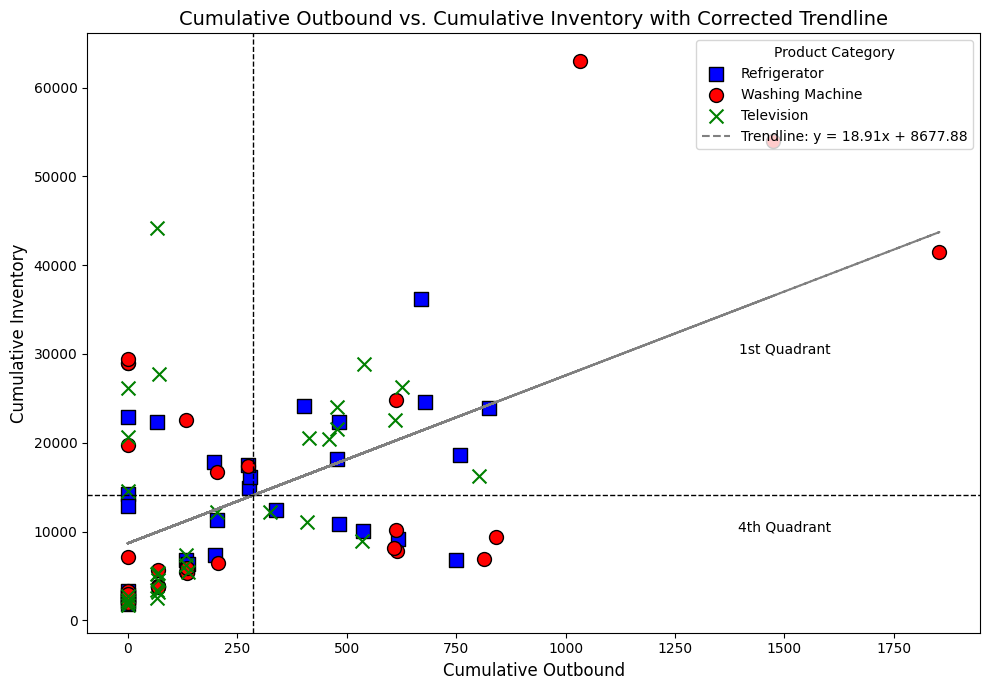

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the data
file_path = '/content/sample_data/5월6월PSI_입출고날짜열로표기.xlsx'  # Replace with your file path
xls = pd.ExcelFile(file_path)

# Load each sheet from the Excel file
initial_inventory = pd.read_excel(xls, sheet_name='기초재고')
inbound = pd.read_excel(xls, sheet_name='입고')
outbound = pd.read_excel(xls, sheet_name='출고')
model_code = pd.read_excel(xls, sheet_name='모델코드')

# Step 2: Reshape inbound and outbound data into long format
inbound_long = inbound.melt(id_vars='모델코드', var_name='날짜', value_name='입고수량')
outbound_long = outbound.melt(id_vars='모델코드', var_name='날짜', value_name='출고수량')

# Step 3: Merge inbound and outbound data
merged_data = pd.merge(inbound_long, outbound_long, on=['모델코드', '날짜'])

# Step 4: Add initial inventory to the merged data
merged_data = pd.merge(merged_data, initial_inventory, on='모델코드')

# Step 5: Add weekday information and sort by model and date
merged_data['날짜'] = pd.to_datetime(merged_data['날짜'], format='%Y-%m-%d')
merged_data['요일'] = merged_data['날짜'].dt.day_name()
merged_data = merged_data.sort_values(by=['모델코드', '날짜'])

# Step 6: Correct the daily final inventory calculation
# Sequentially calculate final inventory based on the previous day's final inventory
merged_data['기말재고_정확한'] = merged_data.groupby('모델코드').apply(
    lambda df: df['기초재고'].iloc[0] + df['입고수량'].cumsum() - df['출고수량'].cumsum()
).reset_index(level=0, drop=True)

# Prepare the result to save in Excel
psi_result = merged_data[['모델코드', '날짜', '출고수량', '입고수량', '요일', '기초재고', '기말재고_정확한']]

# Step 7: Recalculate cumulative inventory and outbound for trendline analysis
cumulative_inventory_corrected = merged_data.groupby('모델코드')['기말재고_정확한'].sum().reset_index()
cumulative_outbound_corrected = merged_data.groupby('모델코드')['출고수량'].sum().reset_index()

# Merge these cumulative calculations
cumulative_corrected = pd.merge(cumulative_inventory_corrected, cumulative_outbound_corrected, on='모델코드')
cumulative_corrected = pd.merge(cumulative_corrected, model_code[['모델코드', '제품군']], on='모델코드')

# Rename the columns for clarity
cumulative_corrected.columns = ['모델코드', '누적재고량_정확한', '누적출고량', '제품군']

# Save the results to a new Excel file
output_file = '/content/sample_data/5월6월PSI결과_열기준.xlsx'
with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
    psi_result.to_excel(writer, sheet_name='검증', index=False)
    cumulative_corrected.to_excel(writer, sheet_name='누적출고재고', index=False)

# Step 8: Calculate the trendline
x_corrected = cumulative_corrected['누적출고량']
y_corrected = cumulative_corrected['누적재고량_정확한']
corrected_coefficients = np.polyfit(x_corrected, y_corrected, 1)  # Linear fit (degree 1)
corrected_trendline = np.poly1d(corrected_coefficients)

# Step 9: Plot the results
product_shapes = {'냉장고': 's', '세탁기': 'o', 'TV': 'x'}
product_colors = {'냉장고': 'blue', '세탁기': 'red', 'TV': 'green'}
legend_labels = {'냉장고': 'Refrigerator', '세탁기': 'Washing Machine', 'TV': 'Television'}

# Create the plot
plt.figure(figsize=(10, 7))

# Plot each product category with its corresponding shape and color
for product, shape in product_shapes.items():
    product_data = cumulative_corrected[cumulative_corrected['제품군'] == product]
    plt.scatter(product_data['누적출고량'], product_data['누적재고량_정확한'],
                label=product, marker=shape, s=100, c=product_colors[product], edgecolor='black')

# Plot the trendline
plt.plot(x_corrected, corrected_trendline(x_corrected), color='gray', linestyle='--', label=f'Trendline: y = {corrected_coefficients[0]:.2f}x + {corrected_coefficients[1]:.2f}')

# Plot the quadrant lines
avg_outbound = cumulative_corrected['누적출고량'].mean()
avg_inventory = cumulative_corrected['누적재고량_정확한'].mean()
plt.axhline(y=avg_inventory, color='black', linestyle='--', linewidth=1)
plt.axvline(x=avg_outbound, color='black', linestyle='--', linewidth=1)

# Add text annotations to indicate 1st and 4th quadrants
plt.text(1500, 30000, '1st Quadrant', fontsize=10, ha='center')
plt.text(1500, 10000, '4th Quadrant', fontsize=10, ha='center')

# Set the axis labels and title
plt.xlabel('Cumulative Outbound', fontsize=12)
plt.ylabel('Cumulative Inventory', fontsize=12)
plt.title('Cumulative Outbound vs. Cumulative Inventory with Corrected Trendline', fontsize=14)

# Update the legend to show product categories in English
plt.legend([legend_labels[product] for product in product_shapes.keys()] + [f'Trendline: y = {corrected_coefficients[0]:.2f}x + {corrected_coefficients[1]:.2f}'], title='Product Category', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


# **도표 13-15. 입출고 일자가 행으로 나열되어 정규화되어 저장된 기준정보**

/tmp/ipython-input-6-3400139430.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_data['기말재고'] = merged_data.groupby('모델코드').apply(


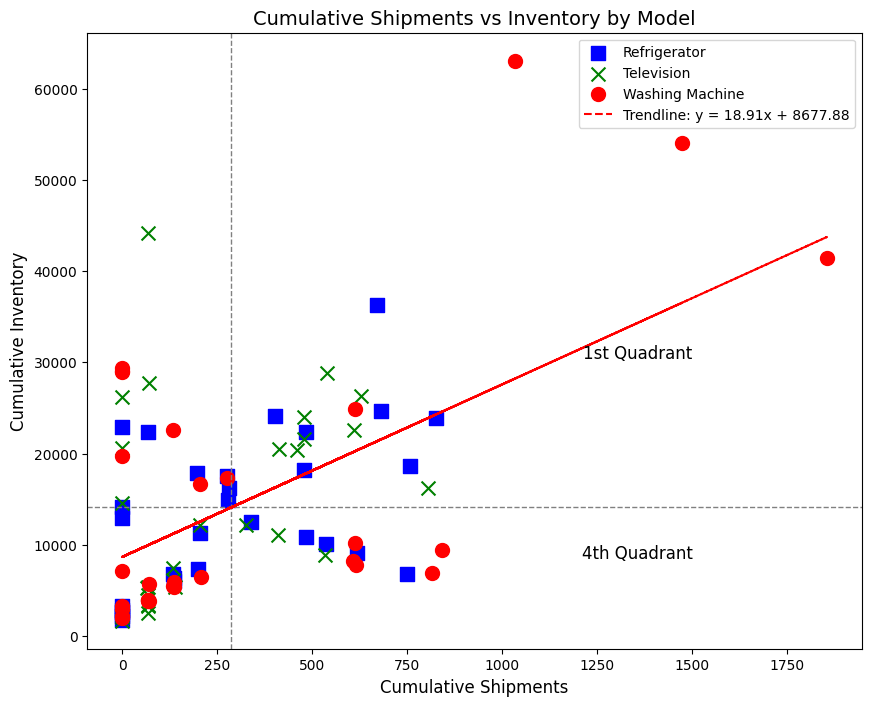

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the Excel file and sheets
file_path = '/content/sample_data/5월6월PSI.xlsx'
ilja_input_output_df = pd.read_excel(file_path, sheet_name='일자별입출고')
initial_inventory_df = pd.read_excel(file_path, sheet_name='기초재고')
model_code_df = pd.read_excel(file_path, sheet_name='모델코드')

# Step 2: Merge initial inventory with daily input/output data and sort by model and date
merged_data = pd.merge(ilja_input_output_df, initial_inventory_df, on="모델코드", how="left")
merged_data['날짜'] = pd.to_datetime(merged_data['날짜'])
merged_data = merged_data.sort_values(by=['모델코드', '날짜'])

# Step 3: Calculate the ending inventory for each day
merged_data['기말재고'] = merged_data.groupby('모델코드').apply(
    lambda df: df['기초재고'].iloc[0] + df['입고수량'].cumsum() - df['출고수량'].cumsum()
).reset_index(drop=True)

# Step 4: Prepare the final dataset with the necessary columns
final_data = merged_data[['모델코드', '날짜', '출고수량', '입고수량', '요일', '기초재고', '기말재고']]

# Step 5: Save this data to a new Excel file
output_file_path = '/content/sample_data/5월6월PSI결과.xlsx'
with pd.ExcelWriter(output_file_path, engine='xlsxwriter') as writer:
    final_data.to_excel(writer, sheet_name='검증', index=False)

# Step 6: Summing the shipment and inventory values for each model across May and June (cumulative)
cumulative_data = merged_data.groupby('모델코드').agg(
    누적출고=('출고수량', 'sum'),
    누적재고=('기말재고', 'sum')
).reset_index()

# Merge with the model codes to get the product groups
cumulative_data = pd.merge(cumulative_data, model_code_df[['모델코드', '제품군']], on='모델코드', how='left')

# Step 7: Compute the average cumulative values to define quadrant boundaries
avg_shipment = cumulative_data['누적출고'].mean()
avg_inventory = cumulative_data['누적재고'].mean()

# Step 8: Translate product group names to English
cumulative_data['제품군'] = cumulative_data['제품군'].replace({
    '냉장고': 'Refrigerator',
    '세탁기': 'Washing Machine',
    'TV': 'Television'
})

# Step 9: Create the scatter plot with the translated product group names
colors = {'Refrigerator': 'blue', 'Washing Machine': 'red', 'Television': 'green'}
markers = {'Refrigerator': 's', 'Washing Machine': 'o', 'Television': 'x'}

x = cumulative_data['누적출고']
y = cumulative_data['누적재고']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

plt.figure(figsize=(10, 8))

# Scatter plot with translated labels
for product_group, group_data in cumulative_data.groupby('제품군'):
    plt.scatter(
        group_data['누적출고'], group_data['누적재고'],
        color=colors[product_group], marker=markers[product_group],
        s=100, label=product_group
    )

# Plot quadrant lines (average cumulative values)
plt.axvline(x=avg_shipment, color='gray', linestyle='--', linewidth=1)
plt.axhline(y=avg_inventory, color='gray', linestyle='--', linewidth=1)

# Add translated quadrant labels
plt.text(1500, 30000, '1st Quadrant', fontsize=12, color='black', verticalalignment='bottom', horizontalalignment='right')
plt.text(1500, 10000, '4th Quadrant', fontsize=12, color='black', verticalalignment='top', horizontalalignment='right')

# Set translated labels and title
plt.xlabel('Cumulative Shipments', fontsize=12)
plt.ylabel('Cumulative Inventory', fontsize=12)
plt.title('Cumulative Shipments vs Inventory by Model', fontsize=14)

# Add a legend in English
plt.legend(title='Product Group')

# Add the translated trend line equation
plt.plot(x, p(x), "r--", label=f"Trendline: y = {z[0]:.2f}x + {z[1]:.2f}")

# Display the updated plot with English translations
plt.legend()
plt.show()

# Step 10: Save the cumulative shipment and inventory data to a new sheet in the same Excel file
with pd.ExcelWriter(output_file_path, engine='xlsxwriter') as writer:
    final_data.to_excel(writer, sheet_name='검증', index=False)
    cumulative_data.to_excel(writer, sheet_name='누적출고재고', index=False)

# The file can be downloaded here:
# output_file_path



